## Import what we need

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Check dataset directory

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os

In [4]:
dataset_dir = "gdrive/MyDrive/Chessman/Chess/"

In [5]:
classes_dir = os.listdir(dataset_dir)
classes_dir

['Pawn', 'Rook', 'Knight', 'King', 'Bishop', 'Queen']

### Create empty lists

In [6]:
train_data = []
train_labels = []
test_data = []
test_labels = []
class_labels = {'Bishop': 0, 'King': 1, 'Knight': 2, 'Pawn': 3, 'Queen':4 , 'Rook': 5}

### Read images using OpenCV

In [7]:
import cv2

In [8]:
for class_name in classes_dir:
    list_images = os.listdir(dataset_dir + class_name)    
    for image_name in list_images:
        img = cv2.imread(os.path.join(dataset_dir, class_name, image_name))
        img = cv2.resize(img, (224, 224))
        rand_num = np.random.rand()
        if rand_num > 0.8:
          test_data.append(img)
          test_labels.append([class_labels[class_name]])
        else:
          train_data.append(img)
          train_labels.append([class_labels[class_name]])

In [9]:
len(train_data), len(train_labels) , len(test_data), len(test_labels) 

(447, 447, 106, 106)

### Convert Python lists to Numpy NDArray

In [10]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [11]:
train_data.shape, type(train_data), train_labels.shape, type(train_labels)

((447, 224, 224, 3), numpy.ndarray, (447, 1), numpy.ndarray)

In [12]:
test_data.shape, type(test_data), test_labels.shape, type(test_labels)

((106, 224, 224, 3), numpy.ndarray, (106, 1), numpy.ndarray)

### Convert labels to one-hot encoding

In [13]:
from tensorflow.keras.utils import to_categorical

In [14]:
train_labels = to_categorical(train_labels)
train_labels.shape, train_labels.dtype

((447, 6), dtype('float32'))

In [15]:
test_labels = to_categorical(test_labels)
test_labels.shape, test_labels.dtype

((106, 6), dtype('float32'))

## Normalize Image Data => between 0 and 1 and float32 dtype

In [16]:
train_data.min(), train_data.max()

(0, 255)

In [17]:
train_data = train_data.astype(np.float32) / 255.0
test_data = test_data.astype(np.float32) / 255.0

In [18]:
train_data.min(), train_data.max(), train_data.shape, train_data.dtype

(0.0, 1.0, (447, 224, 224, 3), dtype('float32'))

In [19]:
test_data.min(), test_data.max(), test_data.shape, test_data.dtype

(0.0, 1.0, (106, 224, 224, 3), dtype('float32'))

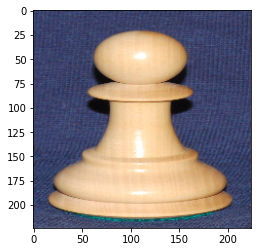

In [20]:
plt.imshow(cv2.cvtColor(train_data[2],cv2.COLOR_BGR2RGB))

In [21]:
train_labels[2]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

# Shuffling

In [22]:
# rs = np.random.get_state()
# np.random.shuffle(train_data)
# np.random.set_state(rs)
# np.random.shuffle(train_labels)

In [23]:
# plt.imshow(cv2.cvtColor(train_data[5],cv2.COLOR_BGR2RGB))

In [24]:
# train_labels[5]

In [25]:
# rs = np.random.get_state()
# np.random.shuffle(test_data)
# np.random.set_state(rs)
# np.random.shuffle(test_labels)

In [26]:
# plt.imshow(cv2.cvtColor(test_data[5],cv2.COLOR_BGR2RGB))

In [27]:
# test_labels[5]

## Now we can create our model

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, Dense, Dropout , ReLU
from tensorflow.keras.applications import MobileNet

In [29]:
base_model = MobileNet(input_shape=(224, 224, 3) , weights='imagenet', include_top=False)
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [30]:
for layer in base_model.layers[:-12]:
  layer.trainable = False

base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

# Create fine_uned Model

In [31]:
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(units=256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(units=6, activation='softmax')(x)

cnn_model = Model(base_model.input, predictions)
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## Compile and Train The Model with EarlyStopping

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=2)

In [34]:
from tensorflow.keras.optimizers import Adam, SGD
cnn_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
cnn_model.fit(x=train_data, y=train_labels, batch_size=16, epochs=200, shuffle=True, validation_data=(test_data, test_labels), callbacks=[early_stop])

Epoch 1/200
28/28 [==============================] - 34s 1s/step - loss: 2.2010 - accuracy: 0.2512 - val_loss: 1.7873 - val_accuracy: 0.3113
Epoch 2/200
28/28 [==============================] - 32s 1s/step - loss: 1.0741 - accuracy: 0.6066 - val_loss: 1.6333 - val_accuracy: 0.3679
Epoch 3/200
28/28 [==============================] - 32s 1s/step - loss: 0.6852 - accuracy: 0.7627 - val_loss: 1.2957 - val_accuracy: 0.5000
Epoch 4/200
28/28 [==============================] - 31s 1s/step - loss: 0.4773 - accuracy: 0.8476 - val_loss: 1.0352 - val_accuracy: 0.6226
Epoch 5/200
28/28 [==============================] - 31s 1s/step - loss: 0.3964 - accuracy: 0.8703 - val_loss: 0.7904 - val_accuracy: 0.7642
Epoch 6/200
28/28 [==============================] - 32s 1s/step - loss: 0.2532 - accuracy: 0.9581 - val_loss: 0.6577 - val_accuracy: 0.7925
Epoch 7/200
28/28 [==============================] - 31s 1s/step - loss: 0.2324 - accuracy: 0.9322 - val_loss: 0.5702 - val_accuracy: 0.7925
Epoch 8/200
2

# Plot Model History

In [36]:
model_history = pd.DataFrame(cnn_model.history.history)

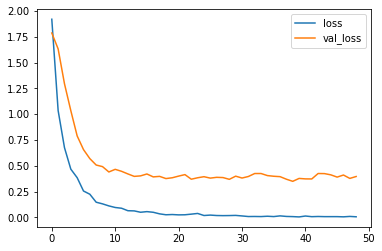

In [37]:
model_history[['loss', 'val_loss']].plot()

#Evaluate Our Model

In [38]:
cnn_model.evaluate(test_data, test_labels)

4/4 [==============================] - 5s 1s/step - loss: 0.3503 - accuracy: 0.9151


[0.3502901792526245, 0.9150943160057068]

#classification_report and confusion_matrix

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
prediction_labels = cnn_model.predict(test_data)
prediction_sparse_labels = np.zeros((len(prediction_labels), ))
prediction_sparse_labels = np.argmax(prediction_labels, axis=1)
prediction_sparse_labels.shape, test_labels.shape

((106,), (106, 6))

In [41]:
prediction_sparse_labels[0], prediction_labels[0]

(0, array([9.6496350e-01, 2.7333913e-04, 6.2614219e-04, 2.9421851e-02,
        4.6738363e-03, 4.1309700e-05], dtype=float32))

#Predict a single image

In [80]:
single_image_prediction = cnn_model.predict(test_data[55].reshape(1, 224, 224, 3))

In [81]:
single_image_prediction.argmax()

2

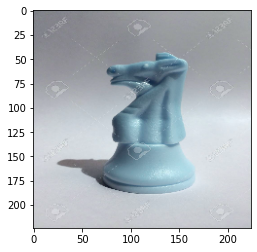

In [83]:
plt.imshow(test_data[55])

# Saving My Model

In [47]:
tf.keras.models.save_model(
    cnn_model, filepath='gdrive/MyDrive/Assets/chessman_2_model.h5', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)